In [1]:
!pip install pymovements
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.1/325.1 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 418.3/418.3 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 121.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
  Attempting uninstall: cryptography
    Found existing installation: cryptography 3.4.8
    Uninstalling cryptography-3.4.8:
      Successfully uninstalled cryptography-3.4.8
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pymovements as pm
dataset = pm.Dataset('ETDD70', path='data/ETDD70')

dataset.download()

edd_raw.zip: 0.00B [00:00, ?B/s]

Checking integrity of edd_raw.zip


edd_fix.zip: 0.00B [00:00, ?B/s]

Checking integrity of edd_fix.zip
Extracting edd_raw.zip to data/ETDD70/raw


100%|██████████| 8/8 [00:00<00:00, 7526.79it/s]


Extracting edd_fix.zip to data/ETDD70/precomputed_events


100%|██████████| 8/8 [00:00<00:00, 5939.89it/s]


In [10]:
# Block 1 (Corrected): Setup and Helper Function
# Purpose: Import libraries, define constants, and create a robust function to process the data.

import os
import glob
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("--- Block 1 (Corrected): Setup and Helper Function ---")

# --- 1. Define Constants and Paths ---
BASE_PATH = 'data/ETDD70/precomputed_events/'
DATA_PATH = os.path.join(BASE_PATH, 'data/data')
LABELS_FILE = os.path.join(BASE_PATH, 'dyslexia_class_label.csv')

# Screen properties for ETDD70 (for spatial normalization)
SCREEN_WIDTH_PX = 1680
SCREEN_HEIGHT_PX = 1050
SCREEN_DIAGONAL_PX = np.sqrt(SCREEN_WIDTH_PX**2 + SCREEN_HEIGHT_PX**2)

# Sequencing parameters
SEQUENCE_LENGTH = 20
STEP = 5

# --- 2. Load Essential Assets ---
try:
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    print("Loaded scaler.pkl from Phase 1.")

    labels_df = pd.read_csv(LABELS_FILE)
    labels_df.rename(columns={'subject_id': 'participant_id', 'label': 'dyslexia_label_str'}, inplace=True)
    labels_df['dyslexia_label'] = labels_df['dyslexia_label_str'].apply(lambda x: 0 if x == 'non-dyslexic' else 1)
    labels_df.set_index('participant_id', inplace=True)
    print("Loaded dyslexia labels.")

except FileNotFoundError as e:
    print(f"ERROR: A required file is missing. {e}") 
    scaler = None
    labels_df = None

# --- 3. Define a Reusable Data Processing Function (Corrected) ---
def process_task_for_participant(participant_id, task_name):
    """
    Loads, harmonizes, scales, and creates sequences for one task for one participant.
    """
    # Find the relevant fixation and saccade files
    fix_file_pattern = os.path.join(DATA_PATH, f'Subject_{participant_id}_*_{task_name}_fixations.csv')
    sacc_file_pattern = os.path.join(DATA_PATH, f'Subject_{participant_id}_*_{task_name}_saccades.csv')

    fix_file = glob.glob(fix_file_pattern)
    sacc_file = glob.glob(sacc_file_pattern)

    if not fix_file or not sacc_file:
        return np.array([]) # Return empty array if data is missing for this task

    # Load data and strip whitespace from column names to prevent KeyErrors
    fix_df = pd.read_csv(fix_file[0])
    fix_df.columns = fix_df.columns.str.strip()
    sacc_df = pd.read_csv(sacc_file[0])
    sacc_df.columns = sacc_df.columns.str.strip()

    # Align saccade data with the FOLLOWING fixation
    sacc_df_shifted = sacc_df.shift(1)

    # Combine the necessary columns into a new DataFrame
    trial_df = pd.DataFrame({
        'fixation_duration': fix_df['duration_ms'],
        'fixation_x': fix_df['fix_x'],
        'fixation_y': fix_df['fix_y'],
        'saccade_amplitude_in': sacc_df_shifted['ampl'],
        'saccade_velocity_in': sacc_df_shifted['avg_vel']
    })

    # Clean and Normalize
    trial_df.fillna(0, inplace=True)
    trial_df = trial_df[trial_df['fixation_duration'].between(80, 1000)].copy()

    # Perform spatial normalization
    trial_df['x_norm'] = trial_df['fixation_x'] / SCREEN_WIDTH_PX
    trial_df['y_norm'] = trial_df['fixation_y'] / SCREEN_HEIGHT_PX
    trial_df['amp_norm'] = trial_df['saccade_amplitude_in'] / SCREEN_DIAGONAL_PX

    # **CRITICAL FIX**: Apply the Phase 1 scaler to the FINAL harmonized features
    kinematic_features = ['fixation_duration', 'x_norm', 'y_norm', 'amp_norm', 'saccade_velocity_in']

    # Ensure the dataframe has the columns in the correct order for the scaler
    feature_df = trial_df[kinematic_features]
    scaled_features = scaler.transform(feature_df)

    # Create sequences from the SCALED features
    sequences = []
    for i in range(0, len(scaled_features) - SEQUENCE_LENGTH + 1, STEP):
        sequences.append(scaled_features[i:i+SEQUENCE_LENGTH])

    return np.array(sequences)

print("Setup complete. Helper function is ready.")
# --- End of Block 1 ---
print("\n" + "="*50 + "\n")

--- Block 1 (Corrected): Setup and Helper Function ---
Loaded scaler.pkl from Phase 1.
Loaded dyslexia labels.
Setup complete. Helper function is ready.




In [11]:
# Block 2 (Corrected): Build the "Participant Packets"
# Purpose: Iterate through all participants and create a single data sample for each,
# containing their sequences for all three tasks.

print("--- Block 2 (Corrected): Building Participant Packets ---")
participant_packets = []
all_participant_ids = sorted(labels_df.index.unique())

if scaler and labels_df is not None:
    for pid in all_participant_ids:
        print(f"Processing participant {pid}...")

        # Process each of the three tasks
        seq_syllables = process_task_for_participant(pid, 'Syllables')
        seq_meaningful = process_task_for_participant(pid, 'Meaningful_Text')
        seq_pseudo = process_task_for_participant(pid, 'Pseudo_Text')

        # Get the dyslexia label for this participant
        label = labels_df.loc[pid]['dyslexia_label']

        # Store the results as a packet
        participant_packets.append({
            'participant_id': pid,
            'sequences_syllables': seq_syllables,
            'sequences_meaningful': seq_meaningful,
            'sequences_pseudo': seq_pseudo,
            'label': label
        }) 

    print("\nAll participants processed.")

    # --- Find the max sequence length for padding ---
    max_len = 0
    for packet in participant_packets:
        max_len = max(max_len, len(packet['sequences_syllables']))
        max_len = max(max_len, len(packet['sequences_meaningful']))
        max_len = max(max_len, len(packet['sequences_pseudo']))
    print(f"Determined max sequence length for padding: {max_len}")

    # --- Assemble final padded NumPy arrays ---
    final_data = {
        'syllables': [],
        'meaningful': [],
        'pseudo': [],
        'labels': []
    }

    # Define the target shape for each participant's task data
    target_shape = (max_len, SEQUENCE_LENGTH, 5)

    for packet in participant_packets:
        # --- FIX: Manual Padding Logic ---
        for task_key in ['syllables', 'meaningful', 'pseudo']:
            sequences = packet[f'sequences_{task_key}']
            num_sequences = sequences.shape[0]

            # Create an empty, zero-filled array of the target shape
            padded_array = np.zeros(target_shape, dtype='float32')

            if num_sequences > 0:
                # Determine how many sequences to copy (handle truncation)
                num_to_copy = min(num_sequences, max_len)
                # Copy the actual data into the padded array
                padded_array[:num_to_copy] = sequences[:num_to_copy]

            final_data[task_key].append(padded_array)

        final_data['labels'].append(packet['label'])

    # Convert lists to final NumPy arrays
    X_syl = np.array(final_data['syllables'])
    X_mean = np.array(final_data['meaningful'])
    X_pse = np.array(final_data['pseudo'])
    y = np.array(final_data['labels'])

    print("\nFinal dataset assembled and padded.")
    print(f"Shape of Syllables data (X_syl): {X_syl.shape}")
    print(f"Shape of MeaningfulText data (X_mean): {X_mean.shape}")
    print(f"Shape of PseudoText data (X_pse): {X_pse.shape}")
    print(f"Shape of labels (y): {y.shape}")

# --- End of Block 2 ---
print("\n" + "="*50 + "\n")

--- Block 2 (Corrected): Building Participant Packets ---
Processing participant 1003...
Processing participant 1009...
Processing participant 1016...
Processing participant 1019...
Processing participant 1021...
Processing participant 1033...
Processing participant 1038...
Processing participant 1040...
Processing participant 1058...
Processing participant 1065...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Sta

Processing participant 1073...
Processing participant 1075...
Processing participant 1082...
Processing participant 1090...
Processing participant 1095...
Processing participant 1109...
Processing participant 1113...
Processing participant 1115...
Processing participant 1134...
Processing participant 1145...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Sta

Processing participant 1160...
Processing participant 1166...
Processing participant 1169...
Processing participant 1174...
Processing participant 1186...
Processing participant 1187...
Processing participant 1189...
Processing participant 1209...
Processing participant 1235...
Processing participant 1254...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Sta

Processing participant 1255...
Processing participant 1257...
Processing participant 1258...
Processing participant 1263...
Processing participant 1271...
Processing participant 1274...
Processing participant 1284...
Processing participant 1300...
Processing participant 1312...
Processing participant 1314...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Sta

Processing participant 1318...
Processing participant 1322...
Processing participant 1345...
Processing participant 1349...
Processing participant 1350...
Processing participant 1377...
Processing participant 1380...
Processing participant 1398...
Processing participant 1405...
Processing participant 1417...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Sta

Processing participant 1421...
Processing participant 1459...
Processing participant 1476...
Processing participant 1571...
Processing participant 1582...
Processing participant 1591...
Processing participant 1626...
Processing participant 1693...
Processing participant 1729...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Sta

Processing participant 1744...
Processing participant 1760...
Processing participant 1858...
Processing participant 1859...
Processing participant 1869...
Processing participant 1879...
Processing participant 1903...
Processing participant 1913...
Processing participant 1929...
Processing participant 1993...
Processing participant 1996...

All participants processed.
Determined max sequence length for padding: 100

Final dataset assembled and padded.
Shape of Syllables data (X_syl): (70, 100, 20, 5)
Shape of MeaningfulText data (X_mean): (70, 100, 20, 5)
Shape of PseudoText data (X_pse): (70, 100, 20, 5)
Shape of labels (y): (70,)




/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Sta

In [12]:
# Block 3: Build the Multi-Input "Reading Profile" Model
# Purpose: Construct the advanced Keras model with three input branches.

from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.models import Model, load_model

print("--- Block 3: Building the Multi-Input Model ---")

if 'max_len' in locals():
    # --- 1. Load the shared encoder and freeze it ---
    encoder = load_model('gaze_encoder_pretrained.h5')
    encoder.trainable = False
    print("Loaded and froze pre-trained encoder.")

    # --- 2. Define the three input layers ---
    input_syllables = Input(shape=(max_len, SEQUENCE_LENGTH, 5), name='input_syllables')
    input_meaningful = Input(shape=(max_len, SEQUENCE_LENGTH, 5), name='input_meaningful')
    input_pseudo = Input(shape=(max_len, SEQUENCE_LENGTH, 5), name='input_pseudo')

    # --- 3. Create a TimeDistributed layer to apply the encoder to each sequence ---
    shared_encoder = TimeDistributed(encoder, name='shared_gaze_encoder')

    # --- 4. Process each input stream through the shared encoder ---
    encoded_syl = shared_encoder(input_syllables)
    encoded_mean = shared_encoder(input_meaningful)
    encoded_pse = shared_encoder(input_pseudo)

    # --- 5. Aggregate the embeddings for each task profile ---
    # GlobalAveragePooling1D will average the 64-dim embeddings across the 'max_len' dimension
    profile_syl = GlobalAveragePooling1D(name='profile_syllables')(encoded_syl)
    profile_mean = GlobalAveragePooling1D(name='profile_meaningful')(encoded_mean)
    profile_pse = GlobalAveragePooling1D(name='profile_pseudo')(encoded_pse)

    # --- 6. Concatenate the three profile vectors into one ---
    concatenated_profile = Concatenate(name='concatenated_profile')([profile_syl, profile_mean, profile_pse])

    # --- 7. Add the final classification head ---
    x = Dense(64, activation='relu', name='head_dense_1')(concatenated_profile)
    x = Dropout(0.5, name='head_dropout')(x)
    output = Dense(1, activation='sigmoid', name='output_classifier')(x)

    # --- 8. Create and compile the final model ---
    profile_model = Model(
        inputs=[input_syllables, input_meaningful, input_pseudo],
        outputs=output
    )
    profile_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("\nMulti-input 'Reading Profile' model built and compiled successfully.")
    profile_model.summary()

# --- End of Block 3 ---
print("\n" + "="*50 + "\n")

--- Block 3: Building the Multi-Input Model ---
Loaded and froze pre-trained encoder.

Multi-input 'Reading Profile' model built and compiled successfully.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_syllables     │ (None, 100, 20,   │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_meaningful    │ (None, 100, 20,   │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_pseudo        │ (None, 100, 20,   │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_gaze_encoder │ (None, 100, 64)   │    118,016 │ input_syllables[… │
│ (TimeDistributed)   │                   │            │ input_meaningful… │
│                     │                   │            │ input_pseudo[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ profile_syllables   │ (None, 64)        │          0 │ shared_gaze_enco… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ profile_meaningful  │ (None, 64)        │          0 │ shared_gaze_enco… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ profile_pseudo      │ (None, 64)        │          0 │ shared_gaze_enco… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenated_profi… │ (None, 192)       │          0 │ profile_syllable… │
│ (Concatenate)       │                   │            │ profile_meaningf… │
│                     │                   │            │ profile_pseudo[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dense_1        │ (None, 64)        │     12,352 │ concatenated_pro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dropout        │ (None, 64)        │          0 │ head_dense_1[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_classifier   │ (None, 1)         │         65 │ head_dropout[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 130,433 (509.50 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 118,016 (461.00 KB)

--- Block 4: Training and Evaluating the Profile Model ---
Data split into 52 training and 18 validation participants.
Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 368s 10s/step - accuracy: 0.5096 - loss: 0.6834 - val_accuracy: 0.5000 - val_loss: 0.6913
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 969ms/step - accuracy: 0.6298 - loss: 0.6650 - val_accuracy: 0.5000 - val_loss: 0.6889
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 952ms/step - accuracy: 0.4878 - loss: 0.6956 - val_accuracy: 0.5000 - val_loss: 0.6865
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 968ms/step - accuracy: 0.7309 - loss: 0.6261 - val_accuracy: 0.5000 - val_loss: 0.6842
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 953ms/step - accuracy: 0.5451 - loss: 0.6644 - val_accuracy: 0.5000 - val_loss: 0.6812
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 969ms/step - accuracy: 0.5688 - loss: 0.6848 - val_accuracy: 0.5000 - val_loss: 0.6770
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 966ms/step - accuracy: 0.7144 - loss: 0.6502 - val_accuracy: 0.6667 - val_loss:

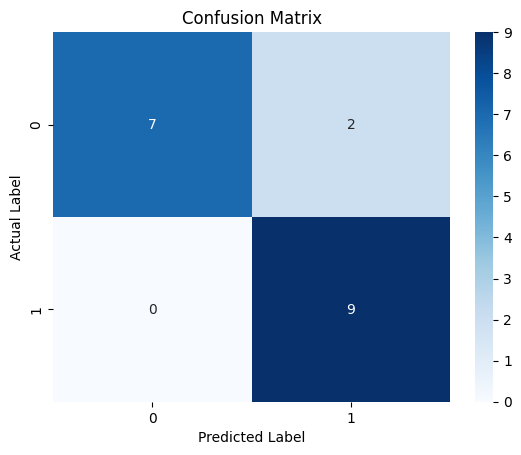

In [13]:
# Block 4: Train and Evaluate the Profile Model
# Purpose: Split the participant-level data, train the model, and evaluate its performance.
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Block 4: Training and Evaluating the Profile Model ---")

if 'profile_model' in locals():
    # --- 1. Split participant data for training and validation ---
    # We create an array of indices to split, ensuring participant data stays together.
    indices = np.arange(len(y))
    train_indices, val_indices = train_test_split(indices, test_size=0.25, random_state=42, stratify=y)

    # Create the training data dictionary
    X_train = {
        'input_syllables': X_syl[train_indices],
        'input_meaningful': X_mean[train_indices],
        'input_pseudo': X_pse[train_indices]
    }
    y_train = y[train_indices]

    # Create the validation data dictionary
    X_val = {
        'input_syllables': X_syl[val_indices],
        'input_meaningful': X_mean[val_indices],
        'input_pseudo': X_pse[val_indices]
    }
    y_val = y[val_indices]

    print(f"Data split into {len(y_train)} training and {len(y_val)} validation participants.")

    # --- 2. Train the model ---
    history = profile_model.fit(
        X_train, y_train,
        epochs=500, # Increased epochs
        batch_size=8, # Use a smaller batch size as we have fewer samples
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        ]
    )

    # --- 3. Evaluate the final model on the validation set ---
    print("\n--- Final Model Evaluation on Validation Set ---")
    y_pred_proba = profile_model.predict(X_val)
    y_pred_class = (y_pred_proba > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_class, target_names=['Non-Dyslexic', 'Dyslexic']))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_val, y_pred_class)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- End of Block 4 ---

In [14]:
# Block 5: Saving the Final Model
# Purpose: Save the best performing model to a file for future use in a real application.

print("--- Block 5: Saving the Final Model ---")

if 'profile_model' in locals():
    # Because we used `restore_best_weights=True` in our EarlyStopping callback,
    # the 'profile_model' object in memory is already loaded with the weights
    # from the best performing epoch. We can now save it directly.

    model_filename = 'dyslexia_profile_model.h5'
    profile_model.save(model_filename)

    print(f"\n✅ Success! The best performing model has been saved to '{model_filename}'.")
    print("This file contains the complete architecture and learned weights.")

else:
    print("Error: 'profile_model' not found in memory. Please re-run the training block.")

# --- End of Block 5 ---


--- Block 5: Saving the Final Model ---

✅ Success! The best performing model has been saved to 'dyslexia_profile_model.h5'.
This file contains the complete architecture and learned weights.


--- Block 6: Visualizing Training History ---
Successfully saved training history plots to 'training_history_plots.png'


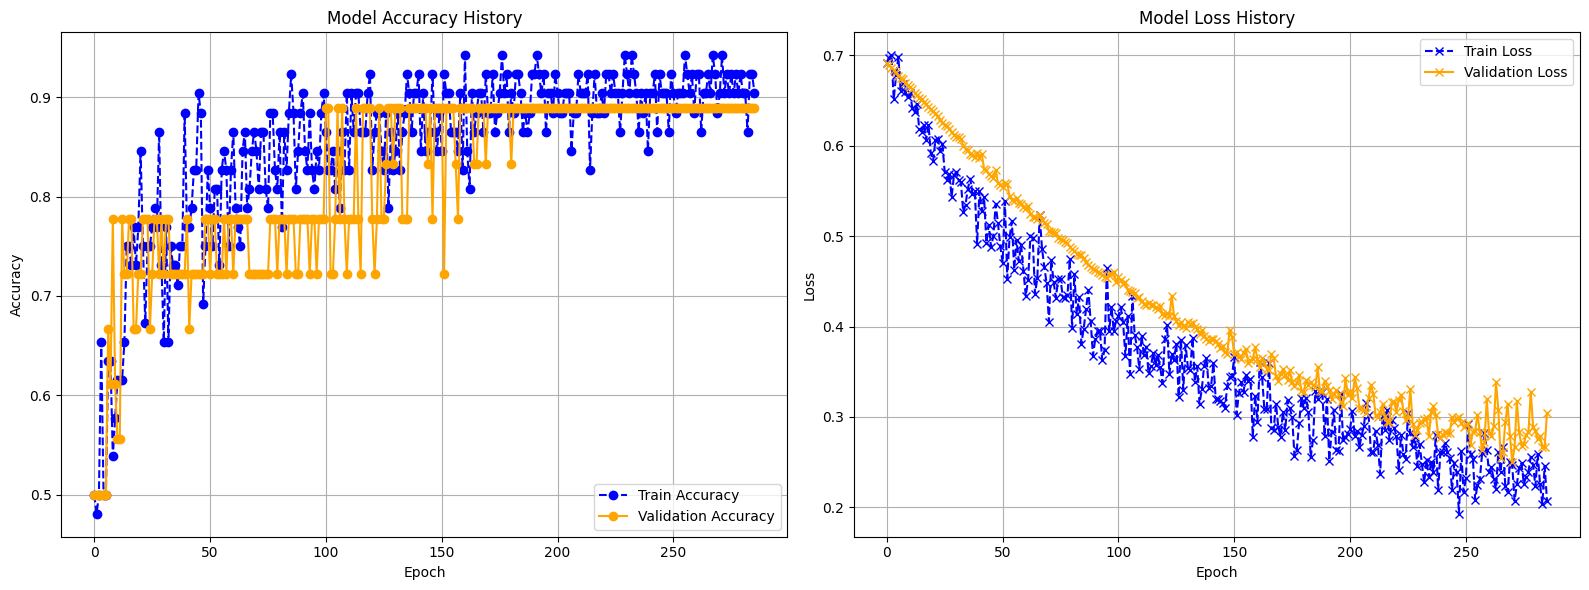

In [15]:
# Block 6: Visualize Training and Validation History
# Purpose: Plot the accuracy and loss curves to understand the model's learning process.

import matplotlib.pyplot as plt

print("--- Block 6: Visualizing Training History ---")

if 'history' in locals():
    # The 'history' object was returned by the model.fit() command.
    # It contains the metrics from each epoch.

    # Create a figure with two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- Plot 1: Accuracy History ---
    ax1.plot(history.history['accuracy'], label='Train Accuracy', color='blue', marker='o', linestyle='--')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='o')
    ax1.set_title('Model Accuracy History')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # --- Plot 2: Loss History ---
    ax2.plot(history.history['loss'], label='Train Loss', color='blue', marker='x', linestyle='--')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='x')
    ax2.set_title('Model Loss History')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history_plots.png')
    print("Successfully saved training history plots to 'training_history_plots.png'")
    plt.show()

else:
    print("Error: 'history' object not found. Please make sure the model training block has been run.")

# --- End of Block 6 ---
